<a href="https://colab.research.google.com/github/Jalalbaim/Auto-Encoder/blob/main/autoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoEncoder
Baim Mohamed

In [126]:
# Libraries

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [127]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [128]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [129]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [130]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()

        self.flatten = nn.Flatten()

        #encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.Tanh(),
            nn.Linear(256, encoding_dim),
            )


        #decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid())

    def forward(self, x):
        x = self.flatten(x)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



autoencoder = Autoencoder(28*28, 16).to(device)
print(autoencoder)


Autoencoder(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [131]:
import torch.nn.functional as F

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

In [132]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)
        X = X.view(-1, 28*28)

        pred = model(X)
        loss = loss_fn(pred, X)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [133]:
def test(dataloader, model, loss_fn):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            X = X.view(-1, 28*28)
            pred = model(X)
            test_loss += loss_fn(pred, X).item()

    num_batches = len(dataloader)
    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")


In [134]:
epochs = 25
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, autoencoder, loss_fn, optimizer)
    test(test_dataloader, autoencoder, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.172048  [    0/60000]
loss: 0.032526  [ 6400/60000]
loss: 0.024666  [12800/60000]
loss: 0.023833  [19200/60000]
loss: 0.021366  [25600/60000]
loss: 0.021124  [32000/60000]
loss: 0.018604  [38400/60000]
loss: 0.016910  [44800/60000]
loss: 0.017702  [51200/60000]
loss: 0.017935  [57600/60000]
Avg loss: 0.017662 

Epoch 2
-------------------------------
loss: 0.017443  [    0/60000]
loss: 0.017059  [ 6400/60000]
loss: 0.015683  [12800/60000]
loss: 0.015366  [19200/60000]
loss: 0.015214  [25600/60000]
loss: 0.015822  [32000/60000]
loss: 0.014755  [38400/60000]
loss: 0.013368  [44800/60000]
loss: 0.014230  [51200/60000]
loss: 0.015009  [57600/60000]
Avg loss: 0.014920 

Epoch 3
-------------------------------
loss: 0.014286  [    0/60000]
loss: 0.014935  [ 6400/60000]
loss: 0.013345  [12800/60000]
loss: 0.013396  [19200/60000]
loss: 0.013390  [25600/60000]
loss: 0.014366  [32000/60000]
loss: 0.013372  [38400/60000]
loss: 0.012417  [44800/60000

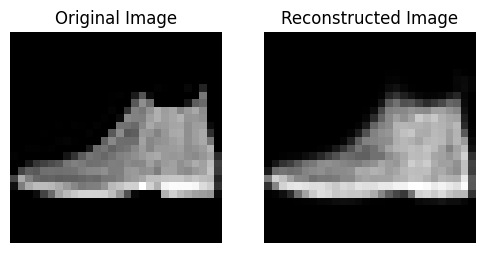

In [135]:
autoencoder.eval()

image = test_data[0][0].unsqueeze(0).to(device)

image_flattened = image.view(-1, 28*28)

with torch.no_grad():
    output = autoencoder(image_flattened)
    output = output.view(28, 28)

figure, ax = plt.subplots(1, 2, figsize=(6, 3))

ax[0].imshow(image[0][0].cpu(), cmap='gray')
ax[0].title.set_text('Original Image')
ax[0].axis('off')


ax[1].imshow(output.cpu(), cmap='gray')
ax[1].title.set_text('Reconstructed Image')
ax[1].axis('off')

plt.show()

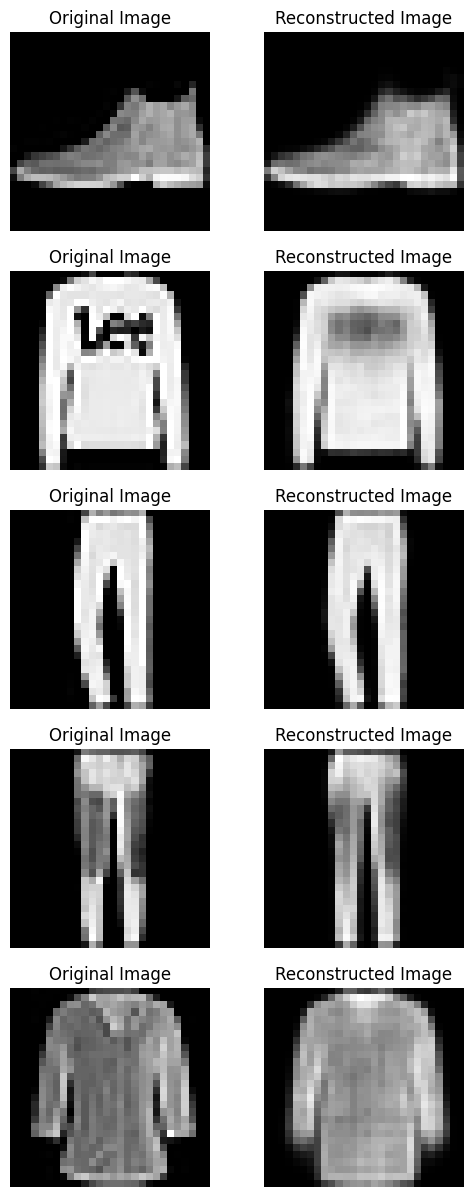

In [137]:

autoencoder.eval()

figure, axes = plt.subplots(5, 2, figsize=(6, 15))


for i in range(5):
    image = test_data[i][0].unsqueeze(0).to(device)

    image_flattened = image.view(-1, 28*28)

    with torch.no_grad():
        output = autoencoder(image_flattened)
        output = output.view(28, 28)

    # Afficher l'image originale
    axes[i, 0].imshow(image[0][0].cpu(), cmap='gray')
    axes[i, 0].title.set_text('Original Image')
    axes[i, 0].axis('off')

    # Afficher l'image reconstruite
    axes[i, 1].imshow(output.cpu(), cmap='gray')
    axes[i, 1].title.set_text('Reconstructed Image')
    axes[i, 1].axis('off')

# Afficher toutes les images
plt.show()
